## Classificação de Spam Usando Ferramentas de NLP e Machine Learning 

#### 1. [Carregando os Dados de Treino](#treino)

#### 2. [Engenharia das Features](#engineering)

* [Derivando Novas Features](#engi-1)

* [Análise Bivarida das Features](#engi-2)

#### 3. [Limpeza do Texto das Mensagens SMS](#clear)

* [Removendo Stopwords](#stop)

* [Lematizando o Texto SMS](#lema)

* [Verificando os N-grams](#grams)

* [Nuvem de Palavras](#cloud) 

#### 4. [Classificando SMS Usando Ensemble Machine Learning](#machine)

* [Vetorizando os Dados](#pre) 

* [Tuning dos Hiperparâmetros](#hiper)

* [Ensemble Stacking: Primeiro Nível](#first) 

* [Ensemble Stacking: Segundo Nível](#secund)

#### 5 [Classificação dos Dados de Teste](#test)

#### 6 [Abordagem não Supervisionada para Classificação dos Textos SMS](#super) 

#### 7 [Salvando os Modelos Treinados](#salve) 


In [1]:
# Importando as bibliotecas necessárias
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from colorama import Fore, Back, Style

import warnings
warnings.filterwarnings("ignore")

## Carregando os Dados de Treino <a class="anchor" id="treino"></a>

In [2]:
# Carregando o dataset de treino 
df = pd.read_csv('train_data.csv', encoding='utf-8')
# Mostrando as cinco primeiras linhas do dataset
df.head()

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked


In [3]:
df.tail()

,SMS,LABEL
5995,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok
5996,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5997,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5998,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok
5999,050003730201|Faça login no aplicativo OlympTra...,ok


In [4]:
# Verificando os valores ausentes no 'train_data'.
df.isnull().sum()

SMS      0
LABEL    0
dtype: int64

Não há valores ausentes.

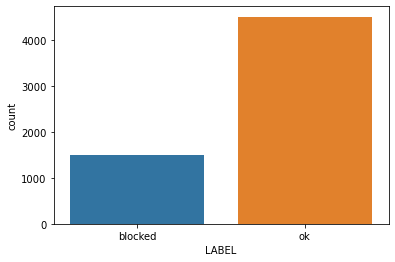

In [5]:
# Exibindo a quantidade de registros de cada classe.
sns.countplot(x = df['LABEL'], data = df);

A classe 'blocked' que representa as mensagens bloqueadas por serem nossivas. Enquanto que a classe 'ok' representam as mensagens seguras.

In [6]:
# Proporção das classes 0  e 1.
df[df['LABEL'] == 'ok']['LABEL'].count()/df[df['LABEL'] == 'blocked']['LABEL'].count()

3.0

## Engenharia de Features <a class="anchor" id="engineering"></a>

Vamos derivar algumas novas features a partir do texto das mensagns e verificar como estas features se comportam em termos das classes 'blocked' e 'ok'.

Primeiramente vamos exibir alguns gráficos sobre propriedades gerais das mensagens sms contidos no dataset. Como por exemplo, podemos mostrar os principais stopwords que ocorrem nos sms. Stopwords são palavras que não tem muita informação para a análise do texto, como artigos, preposições, conjuções etc.

In [7]:
# Importandoos stopwords para textos em português.
nltk.download('stopwords')
stop=set(stopwords.words('portuguese'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


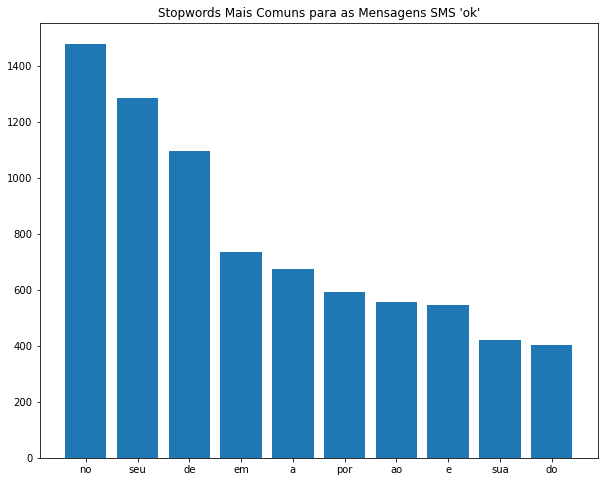

In [8]:
# Criando lista para armazenar os stopwords para a classe 'ok'
corpus_ok = []

sms= df[df['LABEL']==  'ok']['SMS'].str.split()
sms = sms.values.tolist()
corpus_ok = [word for i in sms for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_ok:
    if word in stop:
        dic[word]+=1

# plotando a ocorrência dos stopwords mais comuns
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.figure(figsize=(10, 8))
plt.title("Stopwords Mais Comuns para as Mensagens SMS 'ok'")
plt.bar(x,y);

As Stopswords mais comuns nos sms 'ok' são 'no', 'seu' e 'de'.

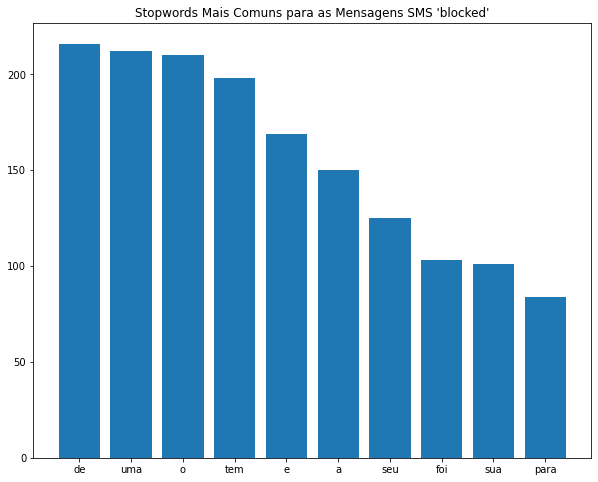

In [9]:
# Criando lista para armazenar os stopwords para a classe 'blocked'.
corpus_bloked=[]

sms= df[df['LABEL']== 'blocked']['SMS'].str.split()
sms = sms.values.tolist()
corpus_bloked=[word for i in sms for word in i]

dic=defaultdict(int)
for word in corpus_bloked:
    if word in stop:
        dic[word]+=1

# plotando a ocorrência dos stopwords mais comuns
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.figure(figsize=(10, 8))
plt.title("Stopwords Mais Comuns para as Mensagens SMS 'blocked'")
plt.bar(x,y);

As Stopswords mais comuns nos sms 'blocked' são 'de', 'uma' e 'o'.

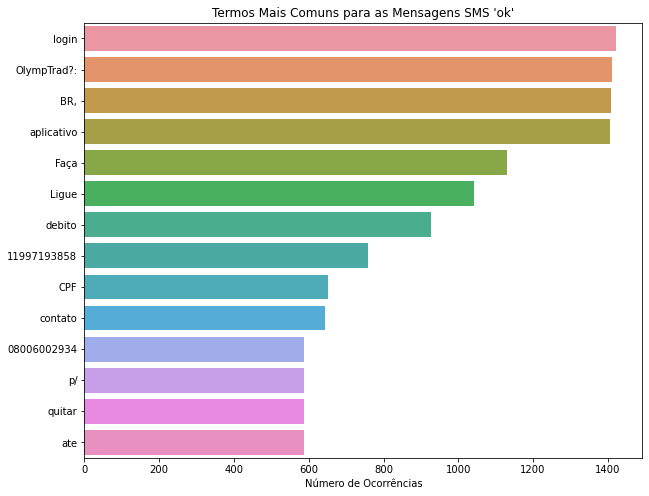

In [10]:
# Mostrando os termos contidos nos textos das mensagens mais comuns da classe 'ok' 

import collections

# Criando contador dos termos mais comuns
counter = collections.Counter(corpus_ok)
most = counter.most_common()

x, y = [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# Plotando os resultados
plt.figure(figsize=(10, 8))        
plt.title("Termos Mais Comuns para as Mensagens SMS 'ok'")
plt.xlabel("Número de Ocorrências")
sns.barplot(x=y,y=x);

Os termos únicos mais frequêntes nos sms 'ok' são 'login', 'OlymTrad?' e 'BR'. Uma observação importante que podemos fazer é que a maioria dos termos no gráfico acima são grafados com letras minúsculas.

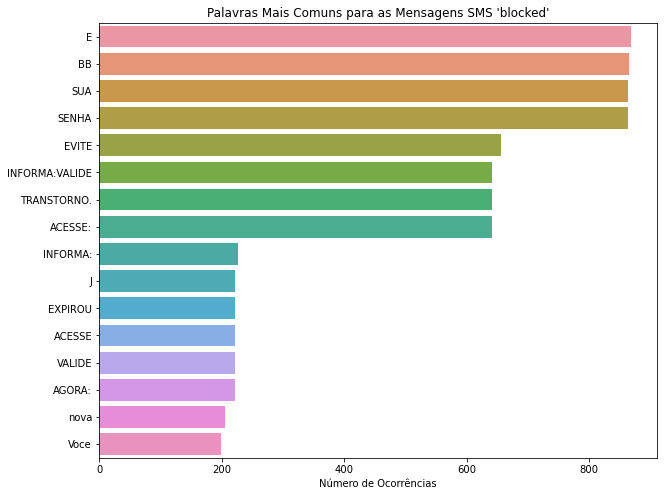

In [11]:
# Mostrando os termos contidos nos textos das mensagens mais comuns da classe 'blocked'

# Criando contador dos termos mais comuns 
counter= collections.Counter(corpus_bloked)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# Plotando os resultados
plt.figure(figsize=(10, 8)) 
plt.title("Palavras Mais Comuns para as Mensagens SMS 'blocked'")  
plt.xlabel("Número de Ocorrências")    
sns.barplot(x=y,y=x);

Os termos únicos mais frequêntes nos sms 'blocked' são 'E', 'BB' e 'SUA'. Aqui observamos que a maioria dos termos no gráfico acima são grafados com letras maisculas.

### Derivando Novas Features <a class="anchor" id="engi-1"></a>

Criamos duas novas features: A primeira representa o comprimento das mensagens em cada registro. A segunda representa a fração da pontuação em relação ao comprimento da mensagem.

In [12]:
# Função para calcular o comprimento da mensagem, excluindo o espaço.
df['SMS_comp'] = df['SMS'].apply(lambda x: len(x) - x.count(" "))

# Função para calcular a fração da pontuação em termos do comprimento da mensagem.
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['ponto%'] = df['SMS'].apply(lambda x: count_punct(x))

df.head()

,SMS,LABEL,SMS_comp,ponto%
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,119,2.5
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,50,16.0
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,46,13.0
3,Atualizacao ainda nao foi executado em sua con...,blocked,96,6.2
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,47,14.9


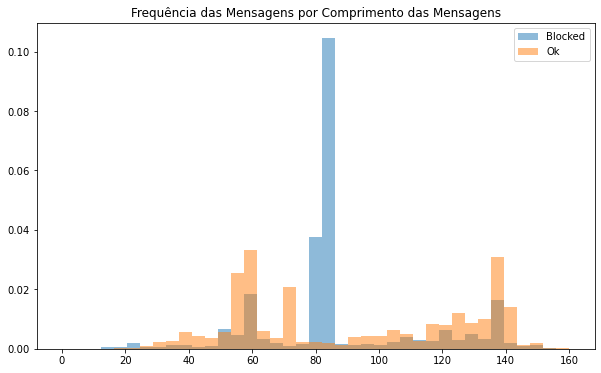

In [13]:
# Exibindo a distribuição dos comprimentos das mensagens para as  classes 'blocked' e 'ok'.

bins = np.linspace(0, 160, 40)

plt.figure(figsize = (10, 6))
plt.hist(df[df['LABEL']== 'blocked']['SMS_comp'], bins, alpha=0.5, density=True, label='Blocked')
plt.hist(df[df['LABEL']== 'ok']['SMS_comp'], bins, alpha=0.5, density=True, label='Ok')
plt.legend(loc='upper right')
plt.title('Frequência das Mensagens por Comprimento das Mensagens')
plt.show()

A quantidade de caracteres, ou comprimento da mensagem, nos regsitros se encontram no intervalo entre  10  e 160 caracteres. Notamos que  mensagens classificadas como 'ok' ocorrem com mais frequência quando posssuem comprimentos da ordem de 60 ou 140. Enquanto que as mensagens 'blocked' possuem uma frequência muito mais expressiva no intervalo da ordem de 80 caracteres. Ou sejá, o gráfico mostra que menssagens com 80 a 85 caracteres possuem muito mais chances de ser uma mensagem que deve ser bloqueada.

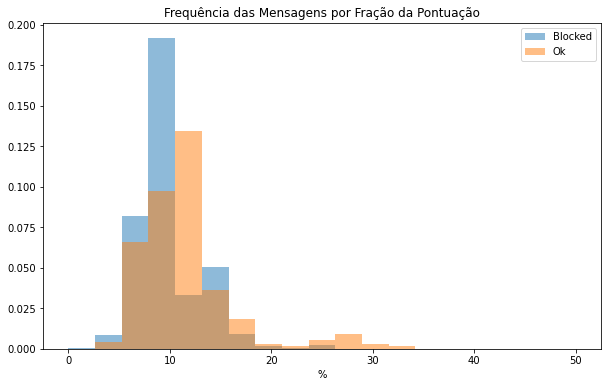

In [14]:
# Exibindo a distribuição da fração da pontuação das mensagens para as classes 'blocked' e 'ok'.

bins = np.linspace(0, 50, 20)

plt.figure(figsize = (10, 6))
plt.hist(df[df['LABEL']== 'blocked']['ponto%'], bins, alpha=0.5, density=True, label='Blocked')
plt.hist(df[df['LABEL']== 'ok']['ponto%'], bins, alpha=0.5, density=True, label='Ok')
plt.title('Frequência das Mensagens por Fração da Pontuação')
plt.xlabel('%')
plt.legend(loc='upper right')
plt.show()

A fração da pontuação em termos da quantidade de caracteres na mensagem para classe 'blocked' é menos frequente do que para a classe 'ok'. Principalmente para as mensagens com 10% de pontuação. Em outras palavras, mensagens contendo uma menor quantidade de pontuação em relação a quantidade total de caracteres são mais prováveis serem  mensagens da classe 'blocked' do que a classe 'ok'.

### Análise Bivariada das Features. <a class="anchor" id="engi-2"></a>

Com a análise bivariada podemos comparar duas variáveis em relação a uma outra. No caso queremos saber como as novas features se relacionam em termos da classes 'ok' e 'blokded'.

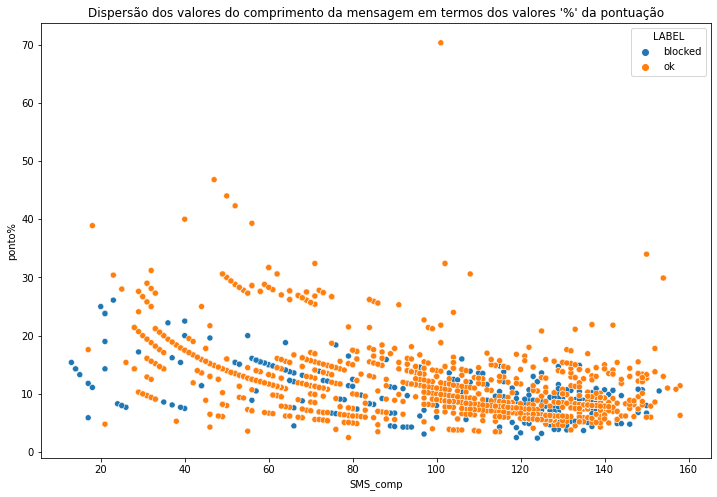

In [15]:
# Na figura abaixo mostramos o gráfico de dispersão das variáveis 'ponto%' e 'sms_com' para as duas classes 
plt.figure(figsize=(12, 8))
sns.scatterplot(x = df['SMS_comp'], y = df['ponto%'], data = df, hue = 'LABEL')
plt.title("Dispersão dos valores do comprimento da mensagem em termos dos valores '%' da pontuação")
plt.show()

É interessante notar que as mensagens classificadas como 'ok' possuem uma dispersão maior do que as mensagens classificadas como 'blocked' quando comparamos a fração de pontuação na mensagem em termos do seu comprimento. Em outros termos, mensagens 'blocked' possuem menos pontuação em relação a seu tamanho total. Uma hipótese para esta observação é que mensagens nocivas devem ser escritas com menos cuidado do que a mensagens seguras.

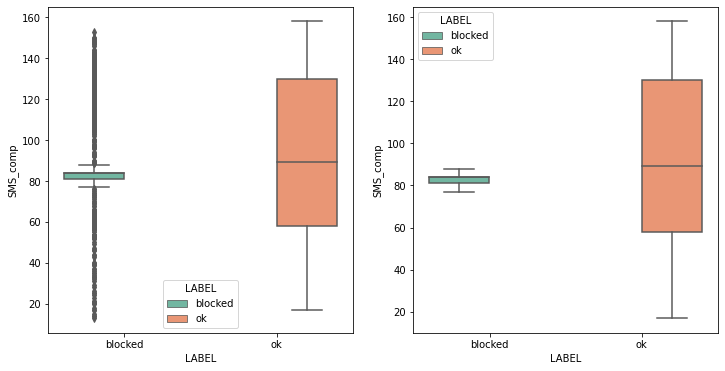

In [16]:
# Exibindo gráficos boxplots para o comprimento das mensagens sms.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="LABEL", y='SMS_comp', hue="LABEL",data=df, palette="Set2",showfliers=True)
s = sns.boxplot(ax = ax2, x="LABEL", y='SMS_comp', hue="LABEL",data=df, palette="Set2",showfliers=False)
plt.show()

Os gráficos de boxplot acima mostram a distribuição dos comprimentos das mensagens sms para as duas classes. Facilmente constatamos que a distribuição dos comprimentos das mensagens para a classe 'blocked' é muito mais concentrada do a classe 'ok'. Esta observação confirma a conclusão anterior de que a grande maioria dos sms 'blocked' possuem comprimentos em torno de 80 caracteres. Outras duas observações importantes que tiramos dos gráficos acima é: A distribuição dos dados dos textos sms 'blocked' são mais assimétricos do a classe 'ok' e que há muitos outliers nesta feature. Podemos inferir com base nestas 
observações, que os textos sms 'blocked' são textos que apresenta uma quantidade de caracteres na ordem de 80 na sua maioria. Além disso,  os demais sms 'blocked' 
possuem uma grande variedade na quantidade de caracteres quando comparamos com a classe 'ok'.

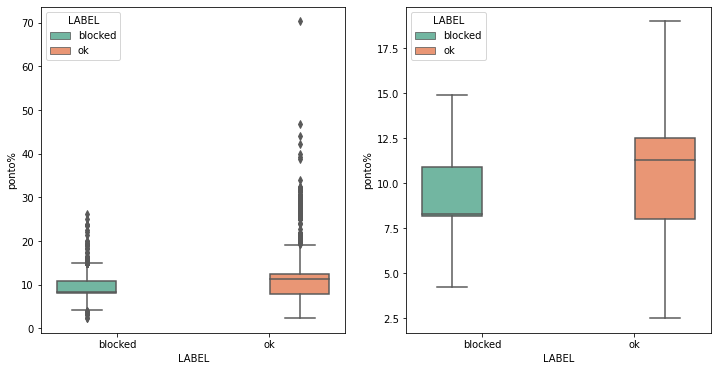

In [17]:
# Exibindo gráficos boxplots para porcentagem da pontuação nas mensagens sms.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="LABEL", y= 'ponto%', hue="LABEL",data=df, palette="Set2",showfliers=True)
s = sns.boxplot(ax = ax2, x="LABEL", y= 'ponto%', hue="LABEL",data=df, palette="Set2",showfliers=False)
plt.show()

A distribuição da pontuação das mensagens para as duas classes mostra que para classe 'blocked' é mais concentrada no valor de 10% do que a classe 'ok'. Isto reafirma a nossa observação de que mensagens 'blocked' possuem menos pontuação em seus textos.

### Limpeza do Texto das Mensagens SMS <a class="anchor" id="clear"></a>

Textos como nossas mensagens sms geralmente contêm sequências de caracteres, palavras e padrões que podem ser interessantes identificarmos no corpo do texto. Para isso, fazemos uso das chamadas expressões regulares, também conhecidas como regex, onde estes podem ser definidos como formas concisas e lógicas de identificar sequências especiais de caracteres. Para identificarmos expressões regulares nos dados vamos definir uma função que possa lidar com a maioria das sequencias de caracteres dentro de textos. Esperamos com este tratamento facilitar a normalização e tokenização dos textos e consequentemente facilita o aprendizagem dos algoritmos de machine learning.

In [18]:
# Criando uma função para lidar com as principais expressões regulares nos textos de sms.
def clean_carater(data):

    # Substituindo enderoço de e-mail por 'email'.
    processed = data.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'email')

    # Substituindo URLs com a expressão 'endereçoweb'.
    processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'endereçoweb')

    # Substituindo simbolos de dinheiro por 'simbolodinheiro'.
    processed = processed.str.replace(r'£|\$', 'simbolodinheiro')
    
    # Substitua os números de telefone de 10 dígitos (os formatos incluem parênteses, espaços, sem espaços, travessões)
    #  por 'númerotelefone'.
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'númerotelefone')
    
    # Substituindo números por 'número'.
    processed = processed.str.replace(r'\d+(\.\d+)?', 'número')

    # Removendo pontuação 
    processed = processed.str.replace(r'[^\w\d\s]', ' ')

    # Substitua o espaço em branco entre os termos por um único espaço.
    processed = processed.str.replace(r'\s+', ' ')

    # Remova os espaços em branco à esquerda e à direita
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    return processed

# Aplicando a função clean_caracter() nos nosso textos sms.
pro = clean_carater(data = df['SMS'])

# Convertemos todos os caracteres maisculos para minúsculos 
processo = pro.str.lower()
print(processo)

0       boleto referente as parcelas em atraso do cons...
1       númerodanúmero lcloud apple lnc com iphone vtb...
2       númerocbnúmerofnúmero ps bancodobrasil seguran...
3       atualizacao ainda nao foi executado em sua con...
4            númerobenúmero ps bancodobrasil seguranca cf
                              ...                        
5995    host rb_bicanga ip número número nao esta resp...
5996    host rb bicanga ip número número nao esta resp...
5997    host rb bicanga ip número número nao esta resp...
5998    host rb_bicanga ip número número nao esta resp...
5999    número faça login no aplicativo olymptrad núme...
Name: SMS, Length: 6000, dtype: object


In [19]:
# Após limparmos o texto, o inserimos no dataset original
pre = pd.DataFrame(data = processo, columns=['SMS'])

dff = df.drop('SMS', axis = 1)
dff = pd.concat([dff, pre], axis = 1)

### Removendo Stopwords <a class="anchor" id="stop"></a>

Remover os stopwors ou palavras sem importância é uma etapa muito importante porque estes conjunto de palavras tem muito pouco ou nenhuma informação para o contexto de aprednizagem dos modelos de machine learning.

In [20]:
# Aqui removemos os stopwords 
stop = set(stopwords.words('portuguese'))
# removendo sinais de pontuação
punctuation = list(string.punctuation)
# Adicionando pontuações à lista de palavras de stopwords 
stop.update(punctuation)

def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Removendo o ruido do texto
def clean_text(text):
    text = remove_stopwords(text)
    return text

dff['SMS'] = dff['SMS'].apply(clean_text)
dff['SMS']

0       boleto referente parcelas atraso consórcio bb ...
1          númerodanúmero lcloud apple lnc iphone vtbqroy
2       númerocbnúmerofnúmero ps bancodobrasil seguran...
3       atualizacao ainda nao executado conta evite bl...
4            númerobenúmero ps bancodobrasil seguranca cf
                              ...                        
5995    host rb_bicanga ip número número nao responden...
5996    host rb bicanga ip número número nao responden...
5997    host rb bicanga ip número número nao responden...
5998    host rb_bicanga ip número número nao responden...
5999    número faça login aplicativo olymptrad número ...
Name: SMS, Length: 6000, dtype: object

### Lematizando os Textos SMS <a class="anchor" id="lema"></a>

O próximo passo é fazer o processo de lematização, este processo permite reduzir as palavras a sua forma base, principalmente no caso de verbos flexionados. Reduzir palavras a sua forma base permite eliminar redundâncias na interpretação dos textos e consequentemente redução no esforço computacional.

In [21]:
# Iniciando a função de lematização com a biblioteca cogroo4py
from cogroo4py.cogroo import Cogroo
cogroo = Cogroo()

# Criando função para lematizar o texto
def lema_coggro(texto):
    for i in range(len(texto)):
        texto.iloc[i] = cogroo.lemmatize(texto.iloc[i])
        
    return texto

# Aplicar função de lematização na coluna do texto
dff['SMS'] = lema_coggro(dff['SMS'])
dff['SMS']

0       boleto referente parcela atrasar consórcio bb ...
1          númerodanúmero lcloud apple lnc iphone vtbqroy
2       númerocbnúmerofnúmero ps bancodobrasil seguran...
3       atualizacao ainda nao executar contar evitar b...
4            númerobenúmero ps bancodobrasil seguranca cf
                              ...                        
5995    host rb  bicanga ip número número nao responde...
5996    host rb bicanga ip número número nao responder...
5997    host rb bicanga ip número número nao responder...
5998    host rb  bicanga ip número número nao responde...
5999    número fazer login aplicativo olymptrad número...
Name: SMS, Length: 6000, dtype: object

### Verificando os N-grams <a class="anchor" id="grams"></a>

N-grams são simplesmente sequências de n-palavras que ocorrem em um texto. Onde por exemplo 'Rua sete' representa um bigram e 'ser ou não' um trigram. Buscar encontram sequências n-grams ajuda a entender o contexto em que determinada palavra foi usada.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer


def plot_top_ngrams_barchart(text, n=1):
    stop=set(stopwords.words('portuguese'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    plt.figure(figsize = (12, 8))
    sns.barplot(x=y,y=x);

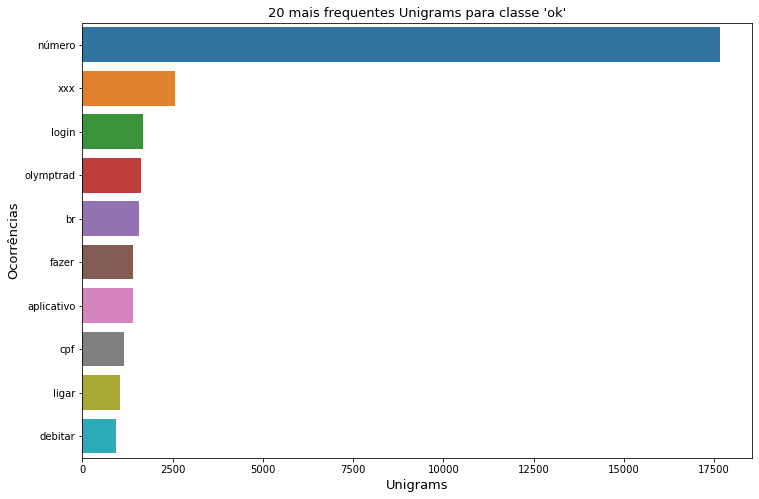

In [23]:
plot_top_ngrams_barchart(dff[dff['LABEL'] == 'ok']['SMS'],1)
plt.title("20 mais frequentes Unigrams para classe 'ok'",  size=(13))
plt.ylabel('Ocorrências', size=(13))
plt.xlabel('Unigrams',  size=(13));

Para classe de sms 'ok' a ocorrência mais comum de unigrams é o termo 'número'. Sendo que este termo representa possivelmente as várias sequências numéricas que tratamos com as expressões regulares anteriormente. 

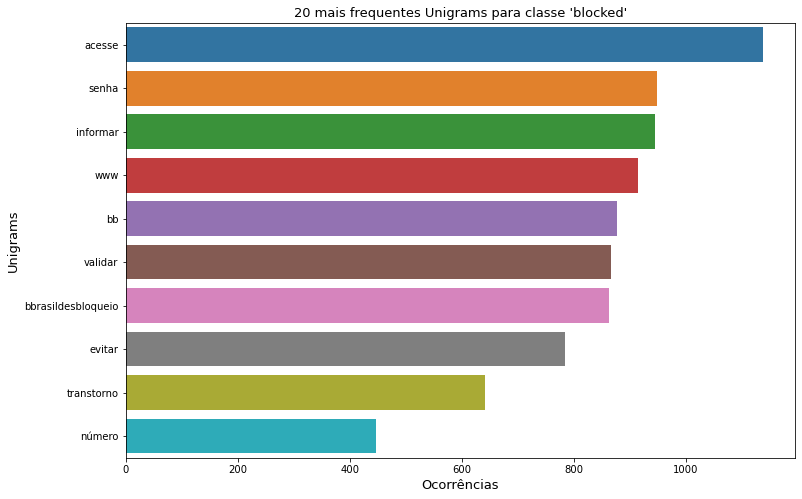

In [24]:
plot_top_ngrams_barchart(dff[dff['LABEL'] == 'blocked']['SMS'],1)
plt.title("20 mais frequentes Unigrams para classe 'blocked'", size=(13))
plt.xlabel('Ocorrências', size=(13))
plt.ylabel('Unigrams', size=(13));

Enquanto que para a classe 'blocked' os três unigrams predominantes são os termos: 'acesse', 'informa', 'www'.

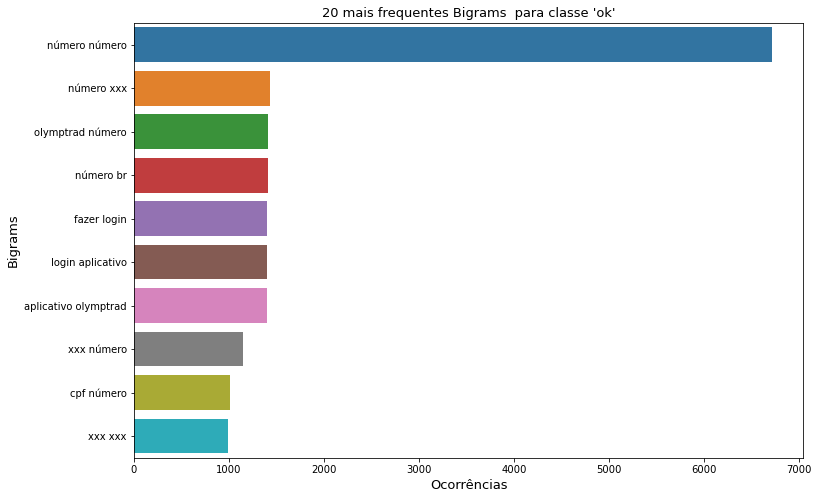

In [25]:
plot_top_ngrams_barchart(dff[dff['LABEL'] == 'ok']['SMS'],2)
plt.title("20 mais frequentes Bigrams  para classe 'ok'", size=(13))
plt.xlabel('Ocorrências', size=(13))
plt.ylabel('Bigrams', size=(13));

Os três bigrams mais frequêntes que obtemos para a classe 'ok' são : 'número número', 'olymptrad número' e 'número xxx'. Mais uma vez sequências numéricas estão bastantes presentes na classes de sms 'ok'.

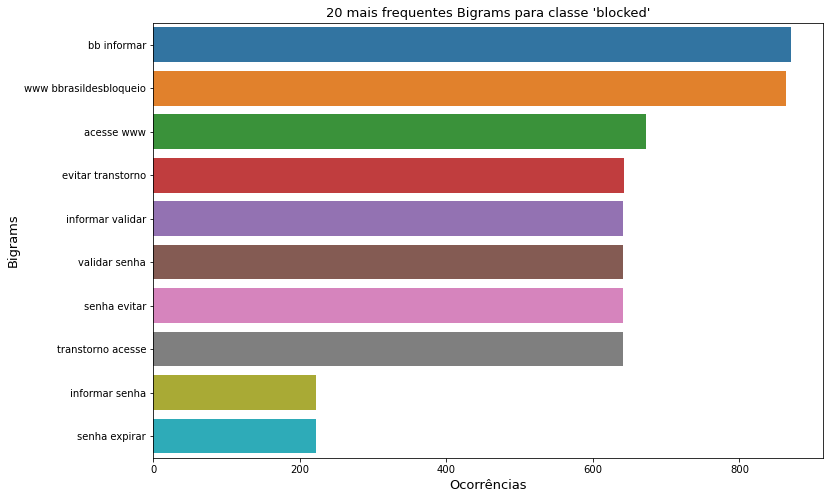

In [26]:
plot_top_ngrams_barchart(dff[dff['LABEL'] == 'blocked']['SMS'],2)
plt.title("20 mais frequentes Bigrams para classe 'blocked'", size=(13))
plt.xlabel('Ocorrências', size=(13))
plt.ylabel('Bigrams', size=(13));

Os três bigrams mais frequêntes que obtemos para a classe 'blocked' são: 'bb informa', 'www brasildesbloqueio' e 'acesse www'. Estes bigrams são muito importantes para detectarmos mensagens sms que devem ser bloqueadas.

### Nuvem de Palavras <a class="anchor" id="cloud"></a>

Uma das técnicas mais utilizadas para análise de textos usando NLP é o conceito de nuvem de palavras (worldcloud). Esta técnica permite visualizarmos facilmente a importância ou frequência de ocorrência de palavras em um texto. O tamanho e a cor com que uma palavra ocorre representa sua importância. 

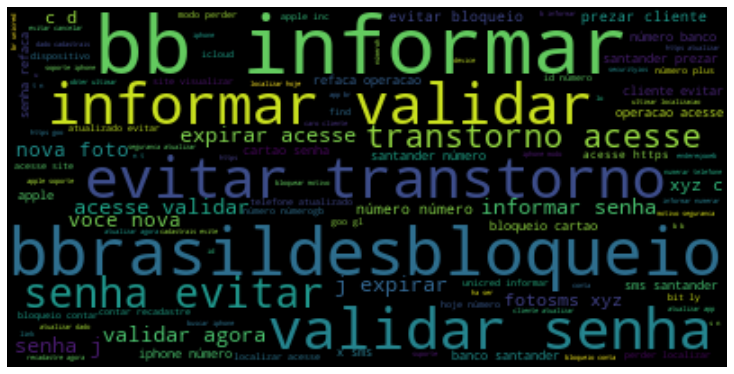

In [27]:
# Nuvem de palavras para a classe 'blocked'
cloud = WordCloud(max_words = 100, stopwords = STOPWORDS, background_color = "black").generate(" ".join(dff[dff.LABEL == 'blocked'].SMS))
plt.figure(figsize=(10, 8))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

A nuvem de palavras resultante para classe 'blocked' evidencia o que já tinhamos visto com análise de n-grams, os termos mais comuns em textos sms nocivos são 'bb informa', 'evite transtorno', etc.

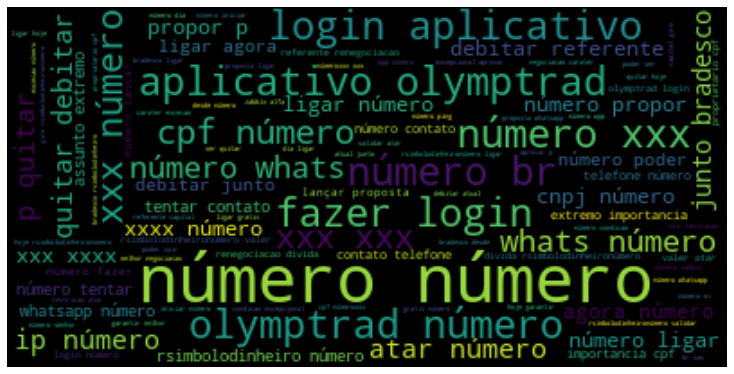

In [28]:
# Nuvem de palavras para a classe 'ok'
cloud = WordCloud(max_words = 100, stopwords = STOPWORDS, background_color = "black").generate(" ".join(dff[dff.LABEL == 'ok'].SMS))
plt.figure(figsize=(10, 8))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Enquanto que para a classe 'ok' os termos mais comuns são bem diferentes dos termos para classe 'blocked'.

## Classificando SMS Usando Ensemble Machine Learning <a class="anchor" id="machine"></a>

Agora que temos os dados analisados e devidamente limpos podemos prepara-los para criarmos os modelos de classificação de textos sms usando algoritmos de machine learning (ML). Nossa estratégia para classificar os textos envolve três procedimentos importantes: 

* A primeira etapa é criamos um ensemble de modelos ml do tipo stacking em dois níveis. A ideia básica de um ensemble stacking é usar um conjunto de modelos para fazer previsões em primeiro nível e em seguida usar estas previsões em um segundo nível, onde um outro modelo fará a previsão final. Esta abordagem é muito boa para termos uma maior confiança nos nossos modelos de previsão, pois esta diminui a suscetibilidade geral deles a bias e a variância. 

* A segunda etapa é tunar os hiperparâmetros de todos os modelos de ML que serão utilizados no primeiro nível do ensemble. Para isso utilizaremos a técnica de random search. Isto permite que nossas modelos possam aprender o máximo possível sobre os nossos dados. 

* A terceira etapa é definir as métricas que utilizaremos para avaliar o desempenho dos nossos modelos de ML e elas são, a log-loss e a ROC-AUC. Estas duas métricas são uma das melhores métricas para medir o desempenho de modelos de classificação. A log-loss, de modo simplificado representa o quão "próximos" os valores preditos estão dos valores reais. Quando menor o valor da log-loss melhor é o modelo. Já métrica ROC-AUC mostra o grau de separabilidade das classes, ou seja, o quão bem os modelos podem distinguir uma classe da outra. Quando mais próximo um ROC-AUC de 1 melhor será o modelo.


### Vetorizando os dados <a class="anchor" id="pre"></a>

Precisamos converter os textos dos nossos dados para um formato numérico, de modo que os modelos possam performar. Geralmente utilizamos a função CountVectorizer para gerar arrays que contam a frequência das palavras no texto. Contudo, esta função não leva em conta o quão importante é a palavras no texto. Então vamos utilizar a função TfidfVectorizer, esta função leva em consideração a importância das palavras, isso permite que modelos aprendam mais sobre os dados.

In [29]:
# Convertendo as palavras dos sms numa matriz de tokens usando a função de TfidfVectorizer()
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
tfidf = tf_idf(norm = None)

tfi_vec =  tfidf.fit(dff['SMS'])
vec = tfi_vec.transform(dff['SMS']).toarray()

# Produzindo um dataframe com os textos sms vectorizados 
reve = pd.DataFrame(vec)
dff.drop(['SMS'], axis = 1, inplace=True)
dff = pd.concat([dff, reve], axis = 1)

In [30]:
# Vamos trocar os valores das labels 'blocked' e 'ok' pelos valores númericos 1 e 0 para facilitar a codificação
dff['LABEL'].replace(['blocked','ok'], [1,0], inplace=True)

In [31]:
# Separando os dados em features e label
X = dff.drop(['LABEL'], axis = 1)

y = dff['LABEL']

Como as classes 'ok'  e 'blocked' são desbalanceadas é interessante concertarmos este desequilibrio, isto porque evitamos assim que o modelo tenha uma preferência de aprendisazem por uma única classe.

In [32]:
# Balanceando as classes 'ok' e 'blocked'
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
X0, y0 = under_sampler.fit_resample(X, y)

### Tuning dos Hiperparâmetros <a class="anchor" id="hiper"></a>

O modelo de stacking que usaremos para fazer nossa classificação terá três modelos de ML no primeiro nível. Os modelos escolhidos foram:

* LGBMClassifier 

* RandomForestClassifier

* catBoostClassifier

Estes modelos são amplamente utilizados em vários tipos de problema de classificação e por isso devem mostra um bom desempenho logo no primeiro nível.

In [ ]:
# Defindo os intervalos de valores que os hiperparâmetros podem assumir para o modelo LGBMClassifier

# Valores para o número de árvores na floresta
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 20)]

# Valores para learning_rate
learning_rate = np.arange(0.005, 0.1, 0.005)

# Valores para max_bin
max_bin = np.arange(1, 15, 1)

# Valores para profundidade das árvores
max_depth = [int(x) for x in np.linspace(4, 24, 2)]

# Criar um radom grid
param = {'n_estimators': n_estimators,
         'learning_rate': learning_rate,
               'max_bin': max_bin,
               'max_depth': max_depth,
               }
print(param)

# Encaixar o grid de hiperparâmetros no modelo de LGBMClassifier
lgbm = LGBMClassifier()
lgbm_randomcv=RandomizedSearchCV(estimator= lgbm, param_distributions=param, n_iter=100, cv=4, verbose=1,
                               random_state=100,n_jobs=-1)

# Encaixar o modelo randomizado 
lgbm_randomcv.fit(X0, y0)

# Exibir os valores dos melhores hiperpârametros para o modelo LGBMClassifier
lgbm_randomcv.best_params_

{'n_estimators': [200, 252, 305, 357, 410, 463, 515, 568, 621, 673, 726, 778, 831, 884, 936, 989, 1042, 1094, 1147, 1200], 'learning_rate': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095]), 'max_bin': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_depth': [4, 24]}
Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 252, 'max_depth': 24, 'max_bin': 13, 'learning_rate': 0.065}

In [ ]:
# Defindo os intervalos de valores que os hiperparâmetros podem assumir para o modelo RandomForestClassifier

# Valores para o número de árvores na floresta
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]

# Valores para profundidade das árvores
max_depth = [int(x) for x in np.linspace(10, 100, 2)]

# Valores mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10,14]

# Valores para o mínimo de amostras necessárias em cada nó folha
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

# Encaixar o modelo randomizado # Encaixar o grid de hiperparâmetros no modelo de RandomForestClassifier
rf = RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=4,verbose=1,
                               random_state=100,n_jobs=-1)

# Encaixar o modelo randomizado
rf_randomcv.fit(X0, y0)

# Exibir os valores dos melhores hiperparâmetros para o modelo RandomForestClassifier
rf_randomcv.best_params_

{'n_estimators': [200, 242, 284, 326, 368, 410, 452, 494, 536, 578, 621, 663, 705, 747, 789, 831, 873, 915, 957, 1000], 'max_depth': [10, 100], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}
Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 578,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 100,
 'criterion': 'gini'}

In [ ]:
# Defindo os intervalos de valores que os hiperparâmetros podem assumir para o modelo CatBoostClassifier

# Valores para profundidade das árvores
max_depth = [int(x) for x in np.linspace(1, 10, 1)]

# Valores para o número de árvores na floresta
iterations = [int(x) for x in np.linspace(100, 1000, 50)]

# Valores para learning_rate
learning_rate = np.arange(0.01, 0.3, 0.01) 

# Valores para a regularização 
l2_leaf_reg = [int(x) for x in np.linspace(1, 50, 5)]

cat_grid = {'max_depth': max_depth,
            'iterations': iterations,
            'learning_rate': learning_rate, 
            'l2_leaf_reg': l2_leaf_reg}

# Encaixar o modelo randomizado # Encaixar o grid de hiperparâmetros no modelo de CatBoostClassifier
cats = CatBoostClassifier()
cats_randomcv=RandomizedSearchCV(estimator=cats,param_distributions=cat_grid,n_iter=100,cv=4,verbose=1,
                               random_state=100,n_jobs=-1)
# Encaixar o modelo randomizado
cats_randomcv.fit(X0, y0)

# Exibir os valores dos melhores hiperparâmetros para o modelo CatBoostClassifier
cats_randomcv.best_params_


Fitting 4 folds for each of 100 candidates, totalling 400 fits
0:	learn: 0.4516040	total: 158ms	remaining: 1m 10s
1:	learn: 0.3277860	total: 167ms	remaining: 37.3s
2:	learn: 0.2507532	total: 175ms	remaining: 25.9s
3:	learn: 0.2099751	total: 182ms	remaining: 20.2s
4:	learn: 0.1795660	total: 194ms	remaining: 17.2s
5:	learn: 0.1489067	total: 204ms	remaining: 15.1s
6:	learn: 0.1328199	total: 212ms	remaining: 13.4s
7:	learn: 0.1155560	total: 221ms	remaining: 12.2s
8:	learn: 0.1111410	total: 229ms	remaining: 11.2s
9:	learn: 0.1036564	total: 237ms	remaining: 10.4s
10:	learn: 0.0948370	total: 244ms	remaining: 9.7s
11:	learn: 0.0923156	total: 253ms	remaining: 9.18s
12:	learn: 0.0897134	total: 261ms	remaining: 8.72s
13:	learn: 0.0841091	total: 268ms	remaining: 8.3s
14:	learn: 0.0801937	total: 275ms	remaining: 7.94s
15:	learn: 0.0786538	total: 282ms	remaining: 7.61s
16:	learn: 0.0729430	total: 290ms	remaining: 7.35s
17:	learn: 0.0723002	total: 297ms	remaining: 7.11s
18:	learn: 0.0715887	total: 30

{'max_depth': 1,
 'learning_rate': 0.21000000000000002,
 'l2_leaf_reg': 13,
 'iterations': 448}

### Ensemble Stacking: Primeiro Nível <a class="anchor" id="first"></a>

In [34]:
# Usando o KFold para validação cruzada dos modelos de primeiro nível
kf = KFold(n_splits= 4, random_state=0, shuffle=True)

# Aqui criamos uma matriz de zeros que receberá o resultado das previsões
second_level = np.zeros((X0.shape[0], 3))

# Definimos uma série de listas vazias para armazenar os valores das métricas de validação
lgbms = []
xgbl = []
lxgbm = []
catm = []
rocm_lgb = []
rocm_xgb = []
rocm_cat = []

for i, (tr, ts) in enumerate(kf.split(X0)):
    Xtr, Xval = X0.iloc[tr], X0.iloc[ts]
    ytr, yval = y0.iloc[tr], y0.iloc[ts]

    lgbm = LGBMClassifier(n_estimators = 726, 
                                learning_rate=0.05, 
                                max_depth= 4, 
                                subsample = 0.8, 
                                max_bin = 7,
                                colsample_bytree=0.8,
                                random_state=9,
                                n_jobs=6)
    
    rfc = RandomForestClassifier(n_estimators = 578,
                                min_samples_split = 5,
                                min_samples_leaf = 1,
                                max_depth = 100, 
                                criterion = 'gini')

    cat = CatBoostClassifier(random_state=123,
                               learning_rate= 0.21,
                               l2_leaf_reg=  13,
                               max_depth= 1,
                               n_estimators= 448,
                               verbose=0)
    
    ########################################

    # Criando os modelos treinados 
    lgbm.fit(Xtr, ytr)
    
    rfc.fit(Xtr, ytr)
    
    cat.fit(Xtr, ytr)
    
    ######################################
    
    # Criando variáveis para receber os valores das probabilidades de previsão para cada classe
    lgb_proba = lgbm.predict_proba(Xval)

    rfc_proba = rfc.predict_proba(Xval)

    cat_proba = cat.predict_proba(Xval)

    ######################################
    
    # Criando variáveis para receber os valores previstos para dada classe
    lgb_p = lgbm.predict(Xval)

    rfc_p = rfc.predict(Xval)

    cat_p = cat.predict(Xval)

    #####################################
    
    # Criando variáveis para receber os valores da métrica logloss

    ll_lgb = log_loss(yval, lgb_proba)

    ll_rfc = log_loss(yval, rfc_proba)

    ll_cat = log_loss(yval, cat_proba)

    #####################################
    
    # Criando variáveis para receber os valores da métrica ROC-AUC

    roc_lgb = roc_auc_score(yval, lgb_p)

    roc_xgb = roc_auc_score(yval, rfc_p)

    roc_cat = roc_auc_score(yval, cat_p)

    #####################################
    
    # Preenchendo as listas coms os valores da logloss
    lgbms.append(ll_lgb)
    lxgbm.append(ll_rfc)
    catm.append(ll_cat)
    
    # Preenchendo as listas coms os valores da ROC-AUC
    rocm_lgb.append(roc_lgb)
    rocm_xgb.append(roc_xgb)
    rocm_cat.append(roc_cat)
    
    # Atribuindo os valores das previsões dos modelos a matriz de zeros
    second_level[ts, 0] = lgb_proba[:, 1]
    second_level[ts, 1] = rfc_proba[:, 1]
    second_level[ts, 2] = cat_proba[:, 1]

# Exibindo as métricas dos modelos de primeiro nível
print(Fore.BLUE + "Log-Loss Média do LightGBM: {:.4f}".format(np.mean(lgbms)))
print(Fore.BLUE + "ROC-AUC Médio do LightGBM: {:.2f}%".format(100*np.mean(rocm_lgb)))

print(Fore.BLUE + "Log-Loss Média do RandomForest: {:.4f}".format(np.mean(lxgbm)))
print(Fore.BLUE + "ROC-AUC Médio do RandomForest: {:.2f}%".format(100*np.mean(rocm_xgb)))

print(Fore.BLUE + "Log-Loss Média do CatBoost: {:.4f}".format(np.mean(catm)))
print(Fore.BLUE + "ROC-AUC Médio do CatBoost: {:.2f}%".format(100*np.mean(rocm_cat)))

Log-Loss Média do LightGBM: 0.0283
ROC-AUC Médio do LightGBM: 99.24%
Log-Loss Média do RandomForest: 0.0251
ROC-AUC Médio do RandomForest: 99.69%
Log-Loss Média do CatBoost: 0.0399
ROC-AUC Médio do CatBoost: 98.97%


### Ensemble Stacking: Segundo Nível <a class="anchor" id="secund"></a>

Usaremos os resultados obtidos pelas previsões  de primeiro de nível como dados para treinar e validar o modelo de segundo nível. O modelo de segundo nível escolhido foi o  modelo LGBMClassifier.

In [ ]:
#  Tunar o modelo ml de segundo nível
lgbm_s = LGBMClassifier()
lgbm_randomcv_s = RandomizedSearchCV(estimator= lgbm_s, param_distributions=param, n_iter=100, cv=4, verbose=1,
                               random_state=100, n_jobs= -1)

# Encaixar o modelo randomizado
lgbm_randomcv_s.fit(second_level, y0)

# Exibir os valores dos melhores hiperpârametros para o modelo
lgbm_randomcv_s.best_params_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 621, 'max_depth': 4, 'max_bin': 13, 'learning_rate': 0.005}

In [89]:
# Criando modelo de segundo nível

# Criando listas vazias para armazenar os valores das log loss e ROC-AUC
ll_stacks = []
rocl_stacks = []

for tr, ts in kf.split(X0,y0):
    
    # Aqui usamos os valores preditos pelos modelos em primeiro nível como features de treino e validação no segundo nível. 
    Xtr, Xval = second_level[tr], second_level[ts]
    ytr, yval = y0.iloc[tr], y0.iloc[ts]
    
    # Usaremos um modelo de Logistic Regression para treinar 
    lgb_stack = LGBMClassifier(n_estimators = 621, 
                                learning_rate=0.005, 
                                max_depth= 4, 
                                subsample = 0.8, 
                                max_bin = 13,
                                colsample_bytree=0.8,
                                random_state=9)

    # Treinando o modelo com dados de primeiro nível
    lgb_stack.fit(Xtr, ytr)
    
    # Criando valores de predição com dados de validação da logistic regression
    pls_stack = lgb_stack.predict(Xval)

    # Criando predições em termos de porcentagem da classes previstas
    sec_stack = lgb_stack.predict_proba(Xval)
    
    # Calculando a função de log loss do modelo Logistic Regression.
    ll_stack = log_loss(yval, sec_stack)

    # Calculando o valor da métrica ROC-AUC
    roc_stack = roc_auc_score(yval, pls_stack) 
    
    # Armazenando os valores da log loss em uma lista para cada split

    ll_stacks.append(ll_stack)

    # Armazenando os valores de ROC-AUC em uma lista para cada split
    rocl_stacks.append(roc_stack)

print(Fore.GREEN + "Loss Médio do LightGBM: {:.4f}".format(np.mean(ll_stacks)))
print(Fore.GREEN + "ROC-AUC Médio do LightGBM: {:.2f}%".format(100*np.mean(rocl_stacks)))

Loss Médio do LightGBM: 0.0524
ROC-AUC Médio do LightGBM: 99.20%


## Classificação dos Dados de Teste <a class="anchor" id="test"></a>

Agora vamos aplicar nosso modelo treinado no segundo nível do ensemble stacking para os dados de validação que o modelo ainda não viu.

In [36]:
# Carregando os dados de validação
vale = pd.read_csv('validation_data.csv', encoding='utf-8')
vale.head()

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...


In [37]:
# Vamos atribuir os valores do dataframe 'vale' a um outro dataframe 'data'
data = vale

### Derivando Novas Features Para os Dados de Teste <a class="anchor" id="test-novos"></a>

In [38]:
# Criando as mesmas features que usamos nos dados de treino nos dados de validação.
data['SMS_comp'] = data['SMS'].apply(lambda x: len(x) - x.count(" "))


data['ponto%'] = data['SMS'].apply(lambda x: count_punct(x))

data.head()

,SMS,SMS_comp,ponto%
0,BB informa:Prezado cliente suas senhas de ACES...,135,7.4
1,BB informa:Prezado cliente suas senhas de ACES...,135,7.4
2,BB informa:Prezado cliente suas senhas de ACES...,135,7.4
3,Node Warning: SFRO01H000001.call.br Warning em...,70,14.3
4,BB informa:Prezado cliente suas senhas de ACES...,135,7.4


In [39]:
# Tratando o texto com a expressões regulares
processed = clean_carater(data = data['SMS'])

processed

0       BB informa Prezado cliente suas senhas de ACES...
1       BB informa Prezado cliente suas senhas de ACES...
2       BB informa Prezado cliente suas senhas de ACES...
3       Node Warning SFROnúmeroHnúmero call br Warning...
4       BB informa Prezado cliente suas senhas de ACES...
                              ...                        
1995    Faça login no aplicativo OlympTrad número núme...
1996    Faça login no aplicativo OlympTrad número núme...
1997    bitnuvem com Identificamos acesso do IP número...
1998      enter in application número número BR Fortaleza
1999    Faça login no aplicativo OlympTrad número núme...
Name: SMS, Length: 2000, dtype: object

In [40]:
# Convertemos todos os caracteres maisculos para minusculos 
processedv = processed.str.lower()

prev = pd.DataFrame(data = processedv, columns=['SMS'])
datas = data.drop('SMS', axis = 1)
datas = pd.concat([datas, prev], axis = 1)

datas.head()

,SMS_comp,ponto%,SMS
0,135,7.4,bb informa prezado cliente suas senhas de aces...
1,135,7.4,bb informa prezado cliente suas senhas de aces...
2,135,7.4,bb informa prezado cliente suas senhas de aces...
3,70,14.3,node warning sfronúmerohnúmero call br warning...
4,135,7.4,bb informa prezado cliente suas senhas de aces...


### Removendo Stopwords dos Dados de Teste  <a class="anchor" id="stop-novos"></a>

In [41]:
# Removendo os stopwords
stop = set(stopwords.words('portuguese'))
# removendo sinais de pontuação
punctuation = list(string.punctuation)
# Adicionando pontuações à lista de palavras de stopwords 
stop.update(punctuation)

def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Removendo o ruido do texto
def clean_text(text):
    text = remove_stopwords(text)
    return text

datas['SMS'] = datas['SMS'].apply(clean_text)
datas['SMS']

0       bb informa prezado cliente senhas acessnúmero ...
1       bb informa prezado cliente senhas acessnúmero ...
2       bb informa prezado cliente senhas acessnúmero ...
3       node warning sfronúmerohnúmero call br warning...
4       bb informa prezado cliente senhas acessnúmero ...
                              ...                        
1995    faça login aplicativo olymptrad número número ...
1996    faça login aplicativo olymptrad número número ...
1997    bitnuvem identificamos acesso ip número número...
1998      enter in application número número br fortaleza
1999    faça login aplicativo olymptrad número número ...
Name: SMS, Length: 2000, dtype: object

### Lematização dos Dados de Teste  <a class="anchor" id="lema-novos"></a>

In [42]:
# Aplicar função de lematização na coluna do texto
datas['SMS'] = lema_coggro(datas['SMS'])
datas['SMS']

0       bb informar prezar cliente senha acessnúmero s...
1       bb informar prezar cliente senha acessnúmero s...
2       bb informar prezar cliente senha acessnúmero s...
3       node warning sfronúmerohnúmero call br warning...
4       bb informar prezar cliente senha acessnúmero s...
                              ...                        
1995    fazer login aplicativo olymptrad número número...
1996    fazer login aplicativo olymptrad número número...
1997    bitnuvem identificar acesso ip número número c...
1998      enter in application número número br fortaleza
1999    fazer login aplicativo olymptrad número número...
Name: SMS, Length: 2000, dtype: object

### Vetorizando os Dados de Teste <a class="anchor" id="vec-novos"></a>

In [43]:
# Convertendo as palavras dos sms numa matriz de tokens usando a função de TfidfVectorizer()
prev_vec = tfi_vec.transform(datas['SMS']).toarray()

reviewsv = pd.DataFrame(prev_vec)

In [44]:
# Produzindo um dataframe com os textos sms vectorizados 
datas.drop(['SMS'], axis = 1, inplace=True)
datas = pd.concat([datas, reviewsv], axis = 1)

### Gerando as Previsões Com os Modelos Treinados <a class="anchor" id="prev-novos"></a>

In [45]:
# Criamos variáveis para recerber as previsões dos modelos treinados usando os dados de validação.
p1 = lgbm.predict(datas)
p2 = rfc.predict(datas)
p3 = cat.predict(datas)

# Criando tabela com valores previstos pelos modelos.
p_stack = np.column_stack((p1, p2, p3))

In [46]:
# Criando variável para receber as previsões feitas pelo modelo com base nos dados das previsões anteriores
pv = lgb_stack.predict(p_stack)

In [47]:
# Criando dataframe com as previsões das classes para os dados de validação.
preds = pd.DataFrame(data = pv, columns = ['Previsão'])

In [48]:
# Renomeando as previsões para as classes 'blocked' e 'ok'.
preds['Previsão'].replace( [1,0], ['blocked','ok'], inplace=True)

preds

,Previsão
0,blocked
1,blocked
2,blocked
3,ok
4,blocked
...,...
1995,ok
1996,ok
1997,ok
1998,ok


In [49]:
# Determinando a proporção das classes previstas
preds[preds['Previsão'] == 'ok'].count()/preds[preds['Previsão'] == 'blocked'].count()

Previsão    3.065041
dtype: float64

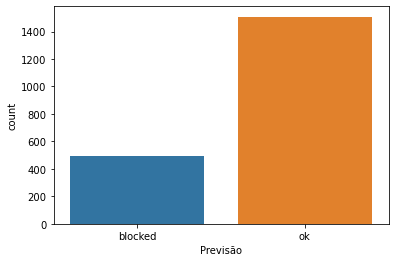

In [50]:
# Plotando as classes previstas
sns.countplot(x = preds['Previsão'], data = preds);

In [51]:
# Criando um dataframe com as classificasões dos textos SMS.
resultado = pd.concat([vale.drop(['SMS_comp', 'ponto%'], axis = 1), preds], axis = 1)
resultado

,SMS,Previsão
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked
...,...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1996,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1997,bitnuvem.com: Identificamos acesso do IP 179.2...,ok
1998,"enterinapplication: 179.240.169.116, BR, For...",ok


In [52]:
# Salvando os dados em um arquivo .csv
resultado.to_csv('validation_data_resultado.csv', index = False)

## Abordagem Não Supervisionada Para Classificação dos Textos SMS <a class="anchor" id="super"></a>

Para termos uma noção de que nossos modelos treinados estão fazendo as previções corretas na mesma proporção que na etapa da validação dos modelos podemos usar a técnica não supervisionada para classificação dos textos. O Algoritmo de KMeans a baixo irá executar a classificação.

In [63]:
# Usando o método não supervisionado para classificar os textos contidos 'valadidation_data.csv'
from sklearn.cluster import KMeans
kmen = []

# Criando o modelo
k = 2
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)

# Treinando o modelo com dados das features 'p_stack'
model.fit(p_stack)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [64]:

stack_cluster = pd.DataFrame(data = p_stack, columns= ['previsão_lgbm', 'previsão_rfc', 'previsão_cat'])

stack_cluster['cluster'] = model.labels_

stack_cluster['cluster'].replace( [1,0], ['blocked','ok'], inplace=True)

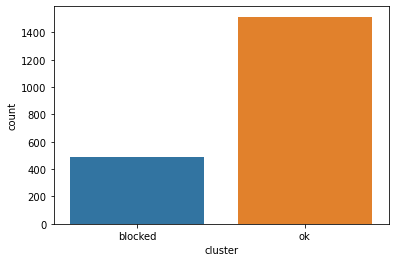

In [68]:
# Plotando os dados classificados com  método não supervisionado
sns.countplot(x = stack_cluster['cluster'], data = stack_cluster);

In [69]:
# Contando a proporção de registros para as classes 'ok' e 'blocked'. 
stack_cluster[stack_cluster['cluster'] == 'ok']['cluster'].count()/stack_cluster[stack_cluster['cluster'] == 'blocked']['cluster'].count()

3.1152263374485596

A proporção das classes para a classifição não supervisionda foi de aproximadamente 3.12 enquanto que para a abordagem supervisionda foi 3.07. A diferença entre ambos os métodos se mostra bem pequena.

In [70]:
resultado['previsão_cluster'] = stack_cluster['cluster'] 

resultado

,SMS,Previsão,previsão_cluster
0,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked,blocked
...,...,...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...,ok,ok
1996,Faça login no aplicativo OlympTrad?: 179.240.1...,ok,ok
1997,bitnuvem.com: Identificamos acesso do IP 179.2...,ok,ok
1998,"enterinapplication: 179.240.169.116, BR, For...",ok,ok


Obtemos uma classificação bem semelhante ao método supervisionado. O que nos dá uma boa noção de que as previsões estão corretas.

In [118]:
q1 = resultado[resultado['Previsão'] == 'blocked']['Previsão'].count()
q2 = resultado[resultado['Previsão'] == 'ok']['Previsão'].count()
q3 = resultado[resultado['previsão_cluster'] == 'blocked']['Previsão'].count()
q4 = resultado[resultado['previsão_cluster'] == 'ok']['Previsão'].count()

print(Fore.GREEN + "SMS bloquados pelo método supervisionado: {:.1f}".format(float(q1)))
print(Fore.GREEN + "SMS aprovados pelo método supervisionado: {:.1f}".format(float(q2)))
print(Fore.RED + "SMS bloquados pelo método de cluster: {:.1f}".format(float(q3)))
print(Fore.RED + "SMS aprovados pelo método cluster: {:.1f}".format(float(q4)))

SMS bloquados pelo método supervisionado: 492.0
SMS aprovados pelo método supervisionado: 1508.0
SMS bloquados pelo método de cluster: 486.0
SMS aprovados pelo método cluster: 1514.0


In [75]:
import numpy as np

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [77]:
sum_of_squares = calculate_wcss(p_stack)

# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(sum_of_squares)

# rodando o kmeans para nossa quantidade ótima de clusters
kmeans = KMeans(n_clusters=n)
clusters = kmeans.fit_predict(p_stack)

## Salvando os Modelos Treinados <a class="anchor" id="salve"></a>

In [71]:
# Importando os 

import pickle 

pickle.dump(lgbm, open('model_lgbm.pkl', 'wb'))

pickle.dump(rfc, open('model_rfc.plk', 'wb'))

pickle.dump(cat, open('model_cat.plk', 'wb'))

pickle.dump(lgb_stack, open('model_lgb_stack.plk', 'wb'))